In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [2]:
x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((54315, 59), (9586, 59), (54315, 1), (9586, 1))

In [3]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
 'Empleado',
 'Saldo_cuenta',
 'Valor_prestamo',
 'Autocontrol',
 'Impulsividad',
 'Confianza' 
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Saldo_cuenta,Valor_prestamo,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,-0.00128,-0.00633,0.00754,-0.00448,0.00228,-0.00068
Saldo_cuenta,-0.00128,1.00000,0.00120,-0.00272,0.00377,-0.00196,-0.00716
Valor_prestamo,-0.00633,0.00120,1.00000,0.00983,-0.00334,-0.00069,-0.00088
Autocontrol,0.00754,-0.00272,0.00983,1.00000,0.00585,0.00627,-0.00449
Impulsividad,-0.00448,0.00377,-0.00334,0.00585,1.00000,-0.00233,-0.00322
Confianza,0.00228,-0.00196,-0.00069,0.00627,-0.00233,1.00000,-0.00062
target,-0.00068,-0.00716,-0.00088,-0.00449,-0.00322,-0.00062,1.00000


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00716
Autocontrol,0.00449
Impulsividad,0.00322
Valor_prestamo,0.00088
Empleado,0.00068
Confianza,0.00062


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Saldo_cuenta,Valor_prestamo,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.00270,-0.00463,0.00647,-0.00503,0.00187,-0.00068
Saldo_cuenta,0.00270,1.00000,0.00463,-0.00199,0.00101,-0.00535,-0.00680
Valor_prestamo,-0.00463,0.00463,1.00000,0.00946,-0.00336,-0.00009,-0.00345
Autocontrol,0.00647,-0.00199,0.00946,1.00000,0.00551,0.00627,-0.00370
Impulsividad,-0.00503,0.00101,-0.00336,0.00551,1.00000,-0.00156,-0.00377
Confianza,0.00187,-0.00535,-0.00009,0.00627,-0.00156,1.00000,-0.00111
target,-0.00068,-0.00680,-0.00345,-0.00370,-0.00377,-0.00111,1.00000


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00680
Impulsividad,0.00377
Autocontrol,0.00370
Valor_prestamo,0.00345
Confianza,0.00111
Empleado,0.00068


In [9]:
del x_train['target']

In [10]:
import statsmodels.api as sm

logit_model_2 = sm.Logit(y_train , x_train[cols_aporte])
result_2 = logit_model_2.fit()

Optimization terminated successfully.
         Current function value: 0.409904
         Iterations 6


In [11]:
#help(logit_model_2.fit)

In [12]:
pesos_ = pd.DataFrame(calcular_pesos(result_2)).reset_index()
pesos_

,index,pesos
0,Saldo_cuenta,0.963098
1,Empleado,7.188732
2,Valor_prestamo,7.840996
3,Impulsividad,24.609024
4,Confianza,28.071359
5,Autocontrol,31.326792


In [13]:
pesos_.to_excel('pesos_originales.xlsx', index=False)

In [14]:
result_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: -0.007    
Dependent Variable: Incumplimiento   AIC:              44539.8899
Date:               2021-06-05 19:06 BIC:              44593.3052
No. Observations:   54315            Log-Likelihood:   -22264.   
Df Model:           5                LL-Null:          -22109.   
Df Residuals:       54309            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Empleado         -0.1828   0.0314  -5.8239 0.0000 -0.2444 -0.1213
Saldo_cuenta     -3.4619   1.6240  -2.1317 0.0330 -6.6449 -0.2789
Valor_prestamo   -0.3630   0.0597  -6.0823 0.0000 -0.4800 -0.2460
Autocontrol      -1.0724   0.0882 -12.1574 0.0000 -1.2453 -0.8995
Impulsividad     -0.9205   0.0854 -10.7753 0.0000 -1.0879 -0.7531
Confianza        -1.0225   0.0888 -11.5084 0.0000 -1.1966 -0.8483
=================================================================

"""

In [15]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict(x_train[cols_aporte])
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict(x_valid[cols_aporte])
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [16]:
pd.Series(y_pred_class_2_train).value_counts()

0    54315
dtype: int64

In [17]:
pd.Series(y_pred_class_2_valid).value_counts()

0    9586
dtype: int64

<AxesSubplot:>

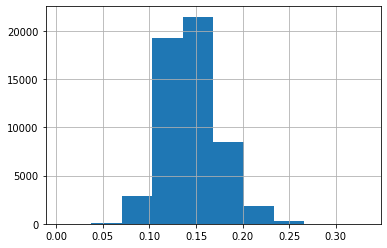

In [18]:
y_pred_prob_2_train.hist()

<AxesSubplot:>

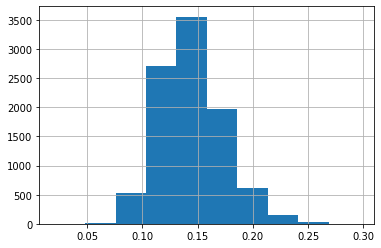

In [19]:
y_pred_prob_2_valid.hist()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, accuracy_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.505
GINI: 0.011
///////////////////////// VALIDATION
AUC: 0.507
GINI: 0.014


In [21]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### >>> RECALL

In [22]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)]
)
optimization_rec

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 7
 success: True
       x: array([0.01298791])

In [23]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.012987907660010789

In [24]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [25]:
pd.Series(y_pred_class_train_2_rec).value_counts()

1    54314
0        1
dtype: int64

In [26]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

1    9586
dtype: int64

In [27]:
print("/"*25, "TRAIN")

print("ACCURACY     : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_rec))
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("ACCURACY     : %1.8f" % accuracy_score(y_valid, y_pred_class_valid_2_rc))
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
ACCURACY     : 0.14117647
RECALL     : 1.00000000
EFECTIVIDAD: 0.14116066
F1 SCORE   : 0.24739840
///////////////////////// VALIDATION
ACCURACY     : 0.14114333
RECALL     : 1.00000000
EFECTIVIDAD: 0.14114333
F1 SCORE   : 0.24737179


#### >>> EFECTIVIDAD

In [28]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)]
)
optimization_pre

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


     fun: -0.3333333333333333
 message: 'Optimization terminated successfully.'
    nfev: 137
     nit: 8
 success: True
       x: array([0.2899879])

#### >>> AUC

In [29]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)]
)
optimization_auc

     fun: -0.5006240300998448
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.10475241])

In [30]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.10475240957750814

In [31]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [32]:
pd.Series(y_pred_class_train_2_auc).value_counts()

1    50828
0     3487
dtype: int64

In [33]:
y_train.value_counts()

Incumplimiento
0                 46648
1                  7667
dtype: int64

In [34]:
pd.Series(y_pred_class_valid_2_auc).value_counts()

1    8989
0     597
dtype: int64

In [35]:
y_valid.value_counts()

Incumplimiento
0                 8233
1                 1353
dtype: int64

In [36]:
print("/"*25, "TRAIN")
print("AC     : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_auc))
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("AC     : %1.8f" % accuracy_score(y_valid, y_pred_class_valid_2_auc))
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
AC     : 0.18753567
RECALL     : 0.93687231
EFECTIVIDAD: 0.14131975
F1 SCORE   : 0.24559364
///////////////////////// VALIDATION
AC     : 0.18693929
RECALL     : 0.94161123
EFECTIVIDAD: 0.14172878
F1 SCORE   : 0.24637401
